## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from kmodes import kprototypes
from SeriesImputer import SeriesImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Load Data

In [364]:
loaded_data = pd.read_csv('./dataset.tsv', sep='\t', na_values=['unknown', -1])

In [2]:
raw_data = loaded_data.copy()

In [3]:
raw_data = raw_data.iloc[:,:8]

## Pre-processing

In [4]:
raw_data.loc[raw_data.x4=='고학력', 'x4'] = 'high'
raw_data.loc[raw_data.x4=='중학력', 'x4'] = 'middle'
raw_data.loc[raw_data.x4=='저학력', 'x4'] = 'low'

In [5]:
# Replace NaN values with mode values
si = SeriesImputer()
raw_data['x2'] = si.fit_transform(raw_data['x2'])
raw_data['x4'] = si.fit_transform(raw_data['x4'])

In [6]:
# Replace binary categorical values with 0, 1
le = LabelEncoder()
raw_data['x5'] = le.fit_transform(raw_data['x5'])
raw_data['x7'] = le.fit_transform(raw_data['x7'])
raw_data['x8'] = le.fit_transform(raw_data['x8'])

In [7]:
# Transform numerical values into same scale (between 0 and 1)
mms = MinMaxScaler()
raw_data['x1'] = mms.fit_transform(raw_data['x1'])
raw_data['x6'] = mms.fit_transform(raw_data['x6'])

/Users/Coupang/anaconda/envs/tf3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/Coupang/anaconda/envs/tf3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Coupang/anaconda/envs/tf3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, Deprecatio

In [8]:
raw_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8
0,0.519481,management,married,high,0,0.020984,1,0
1,0.337662,technician,single,middle,0,0.000284,1,0
2,0.194805,entrepreneur,married,middle,0,0.000020,1,1
3,0.376623,blue-collar,married,middle,0,0.014746,1,0
4,0.194805,management,single,middle,0,0.000010,0,0


## Random Sampling for deciding number of clusters

In [10]:
use_data = raw_data.sample(frac=0.1, replace=False)

## Find proper number of clusters with elbow method

In [11]:
use_array = use_data.as_matrix()
costs=[]

In [12]:
for i in range(1, 10):
    kproto = kprototypes.KPrototypes(n_clusters=i,
                                    init='random')
    clusters = kproto.fit_predict(use_array, categorical=[1,2,3,4,6,7])
    costs.append(kproto.cost_)
    print("Cost for %s clusters : %.2f" % (i, kproto.cost_))
print(costs)

Cost for 1 clusters : 875.35
Cost for 2 clusters : 666.88
Cost for 3 clusters : 582.33
Cost for 4 clusters : 537.68
Cost for 5 clusters : 502.79
Cost for 6 clusters : 470.57
Cost for 7 clusters : 437.91
Cost for 8 clusters : 415.97
Cost for 9 clusters : 409.92
[875.35182878809792, 666.88044167447367, 582.32784838290729, 537.68389229688023, 502.79298376095414, 470.57031938741795, 437.91352795687033, 415.97393310074949, 409.92467334988356]


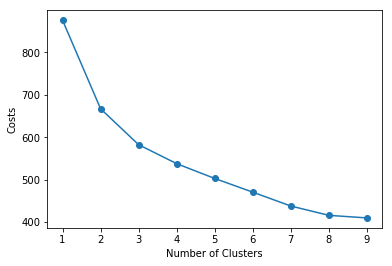

In [13]:
plt.plot(range(1,10), costs, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Costs')
plt.show()

## Clustering with all samples

In [23]:
kproto_all = kprototypes.KPrototypes(n_clusters=3, n_init=1, init='random')

In [24]:
raw_array = raw_data.as_matrix()

In [25]:
raw_array.shape

(40000, 8)

In [26]:
clusters_all = kproto_all.fit_predict(raw_array, categorical=[1,2,3,4,6,7])

In [27]:
kproto_all.cluster_centroids_

[array([[ 0.28035906,  0.01794572],
        [ 0.36270158,  0.01574009],
        [ 0.25722895,  0.01164447]]),
 array([['management', 'married', 'high', '0', '1', '0'],
        ['technician', 'married', 'middle', '0', '0', '0'],
        ['blue-collar', 'married', 'middle', '0', '1', '0']], 
       dtype='<U21')]

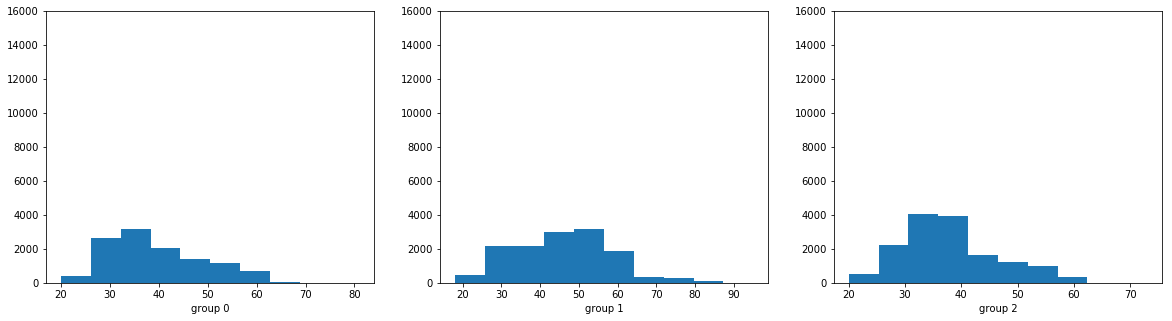

In [391]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
for i in np.unique(clusters_all):
    ax[i].hist(loaded_data['x1'][clusters_all==i])
    ax[i].set_xlabel("group %s" % i)
    ax[i].set_ylim([0, 16000])
plt.show()

In [394]:
age_df = pd.DataFrame()
for i in np.unique(clusters_all):
    cl_df = pd.DataFrame(loaded_data['x1'][clusters_all==i].describe())
    age_df = pd.concat([age_df, cl_df], axis=1)
age_df.columns = [0,1,2]

In [395]:
age_df

,0,1,2
count,11609.000000,13518.000000,14873.000000
mean,39.587648,45.928022,37.806629
std,9.390667,12.286381,8.408679
min,20.000000,18.000000,20.000000
25%,32.000000,36.000000,32.000000
50%,37.000000,46.000000,36.000000
75%,46.000000,55.000000,43.000000
max,81.000000,95.000000,73.000000


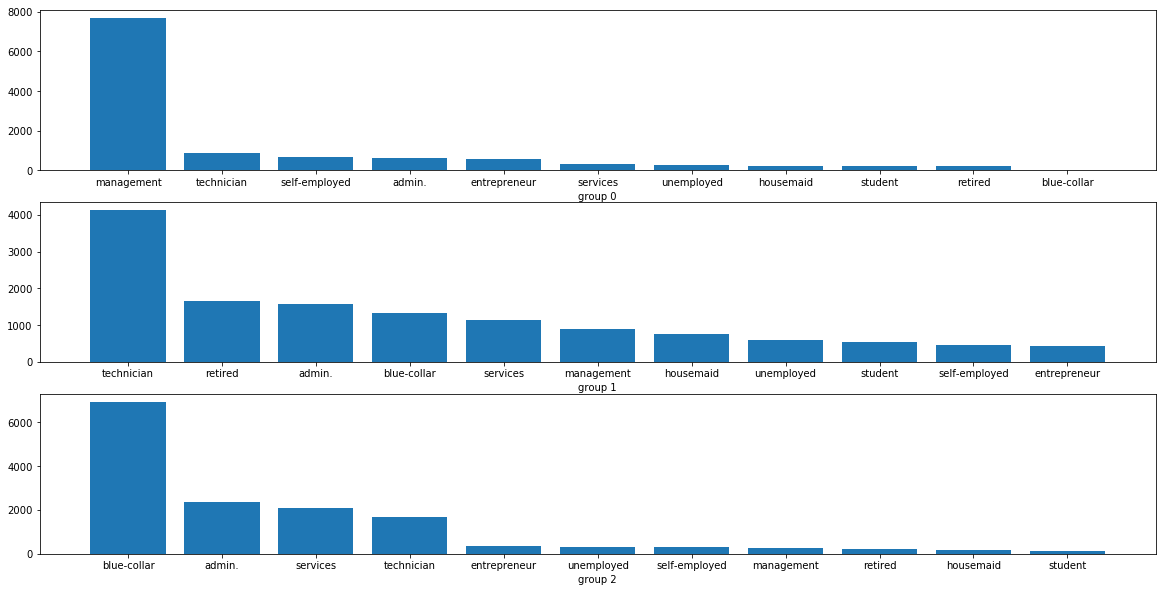

In [342]:
## x2 jobs
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
for i in np.unique(clusters_all):
    vc = pd.DataFrame(raw_data[clusters_all==i].x2.value_counts().reset_index())
    cols = np.array(vc['index'])
    pos = np.arange(len(vc.iloc[:,0]))
    ax[i].bar(pos, vc.iloc[:,1])
    ax[i].set_xlabel("group %s" % i)
    ax[i].set_xticks(pos)
    ax[i].set_xticklabels(cols)
plt.show()

In [302]:
kproto_all.cluster_centroids_

[array([[ 0.20183294,  0.01254177],
        [ 0.31859395,  0.01819414],
        [ 0.35386211,  0.01373031]]),
 array([['technician', 'single', 'middle', '0', '1', '0'],
        ['management', 'married', 'high', '0', '0', '0'],
        ['blue-collar', 'married', 'middle', '0', '1', '0']], 
       dtype='<U21')]

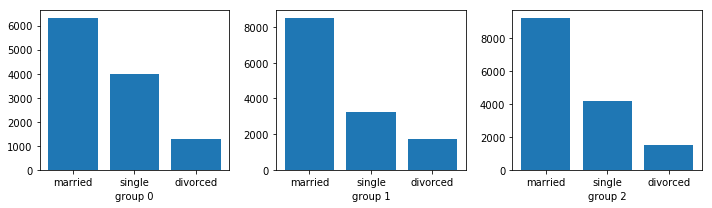

In [352]:
## x3 marriage
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for i in np.unique(clusters_all):
    vc = pd.DataFrame(raw_data[clusters_all==i].x3.value_counts().reset_index())
    cols = np.array(vc['index'])
    pos = np.arange(len(vc.iloc[:,0]))
    ax[i].bar(pos, vc.iloc[:,1])
    ax[i].set_xlabel("group %s" % i)
    ax[i].set_xticks(pos)
    ax[i].set_xticklabels(cols)
plt.tight_layout()
plt.show()

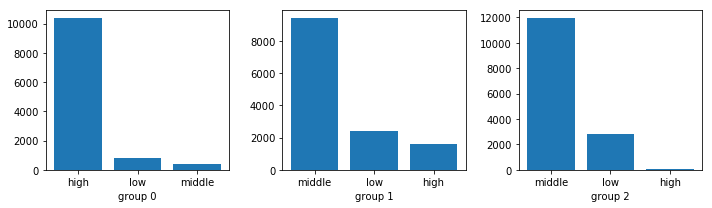

In [353]:
## x4 education
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for i in np.unique(clusters_all):
    vc = pd.DataFrame(raw_data[clusters_all==i].x4.value_counts().reset_index())
    cols = np.array(vc['index'])
    pos = np.arange(len(vc.iloc[:,0]))
    ax[i].bar(pos, vc.iloc[:,1])
    ax[i].set_xlabel("group %s" % i)
    ax[i].set_xticks(pos)
    ax[i].set_xticklabels(cols)
plt.tight_layout()
plt.show()

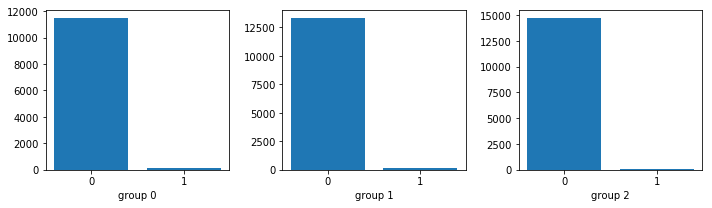

In [354]:
## x5 default
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for i in np.unique(clusters_all):
    vc = pd.DataFrame(raw_data[clusters_all==i].x5.value_counts().reset_index())
    cols = np.array(vc['index'])
    pos = np.arange(len(vc.iloc[:,0]))
    ax[i].bar(pos, vc.iloc[:,1])
    ax[i].set_xlabel("group %s" % i)
    ax[i].set_xticks(pos)
    ax[i].set_xticklabels(cols)
plt.tight_layout()
plt.show()

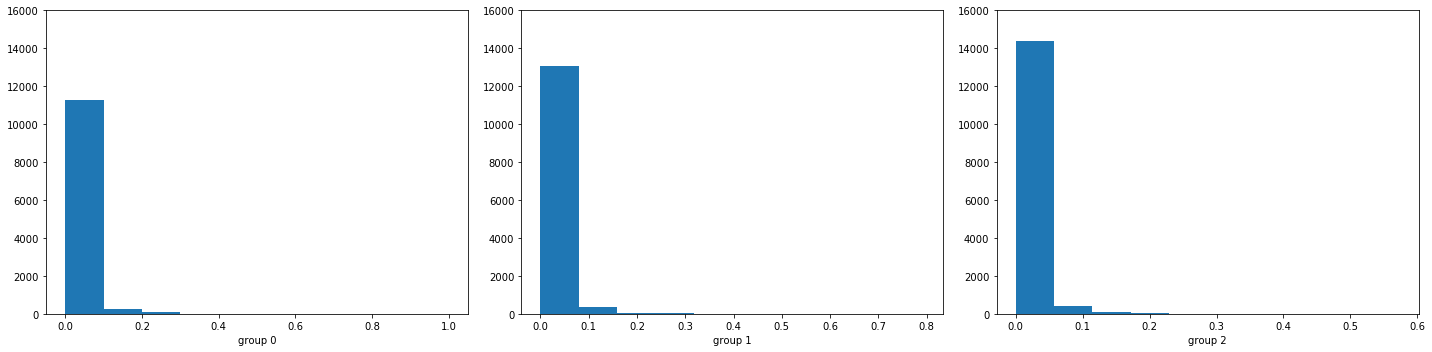

In [355]:
## x6 balance
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
for i in np.unique(clusters_all):
    ax[i].hist(raw_data['x6'][clusters_all==i])
    ax[i].set_xlabel("group %s" % i)
    ax[i].set_ylim([0, 16000])
plt.tight_layout()
plt.show()

In [396]:
balance_df = pd.DataFrame()
for i in np.unique(clusters_all):
    cl_df = pd.DataFrame(loaded_data['x6'][clusters_all==i].describe())
    balance_df = pd.concat([balance_df, cl_df], axis=1)
balance_df.columns = [0,1,2]

In [397]:
balance_df

,0,1,2
count,11609.000000,13518.000000,14873.000000
mean,1832.742786,1607.488312,1189.214281
std,3779.577328,3407.688282,2192.184981
min,0.000000,0.000000,0.000000
25%,168.000000,130.000000,146.000000
50%,633.000000,568.000000,476.000000
75%,1884.000000,1755.000000,1279.000000
max,102127.000000,81204.000000,58544.000000


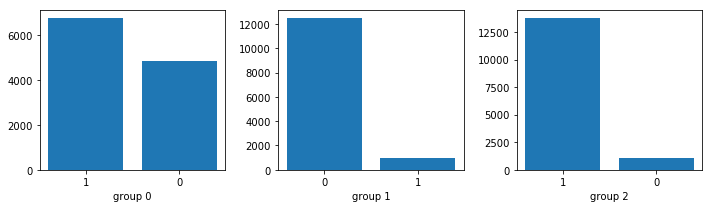

In [372]:
## x7 housing loan
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for i in np.unique(clusters_all):
    vc = pd.DataFrame(raw_data[clusters_all==i].x7.value_counts().reset_index())
    cols = np.array(vc['index'])
    pos = np.arange(len(vc.iloc[:,0]))
    ax[i].bar(pos, vc.iloc[:,1])
    ax[i].set_xlabel("group %s" % i)
    ax[i].set_xticks(pos)
    ax[i].set_xticklabels(cols)
plt.tight_layout()
plt.show()

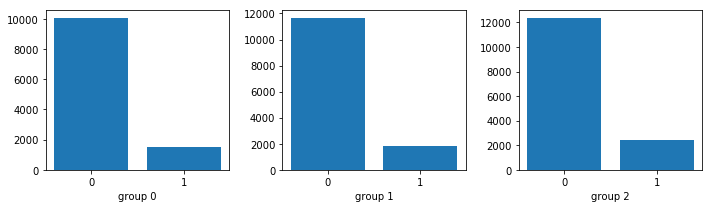

In [373]:
## x8 credit loan
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for i in np.unique(clusters_all):
    vc = pd.DataFrame(raw_data[clusters_all==i].x8.value_counts().reset_index())
    cols = np.array(vc['index'])
    pos = np.arange(len(vc.iloc[:,0]))
    ax[i].bar(pos, vc.iloc[:,1])
    ax[i].set_xlabel("group %s" % i)
    ax[i].set_xticks(pos)
    ax[i].set_xticklabels(cols)
plt.tight_layout()
plt.show()